# Australian Retail Customer Segmentation Project

## Project Overview  
The main objective of this project was to streamline marketing strategies and provide retail firms with insights into how and where they can better focus their efforts—both in terms of products and customer targeting. This analysis uses the open-source **Australia Retail Data** from Kaggle: [Australia Retail Data](https://www.kaggle.com/datasets/chickenfulleton/australia-retail-data).

## Code Structure  
The code is organized to follow a clean and logical data science workflow. It includes:

- **Data Import and Exploration**  
- **Data Cleaning and Preprocessing**:  
  - Addressing format inconsistencies  
  - Handling missing values  
  - Fixing invalid `order_no` values (notably, 72.54% were inconsistent)  
  - Assigning meaningful `transaction_id` values based on cart-level consistency  
- **Recalculation of Financial Metrics**:  
  - Ensuring accurate `subtotal`, `discount`, `order_total`, and `total` values  
- **Outlier Detection and Treatment**:  
  - Using the IQR method followed by Winsorization  
- **RFM Segmentation Preparation**:  
  - Calculating Recency, Frequency, Monetary values  
  - Normalizing values for clustering  
- **K-Means Clustering**:  
  - Using Elbow and Silhouette methods to determine optimal clusters  
  - Applying K-Means with 3 clusters  
- **Final DataFrame for Power BI**:  
  - Clean, customer-level dataset prepared for business-friendly dashboarding

### Data Import and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns',24)

df=pd.read_csv("dataaus.csv")

In [2]:
df.head()

,Order No,Order Date,Customer Name,Address,City,State,Customer Type,Account Manager,Order Priority,Product Name,Product Category,Product Container,Ship Mode,Ship Date,Cost Price,Retail Price,Profit Margin,Order Quantity,Sub Total,Discount %,Discount $,Order Total,Shipping Cost,Total
0,4293-1,2/9/2019,Vivek Sundaresam,"152 Bunnerong Road,Eastgardens",Sydney,NSW,Small Business,Tina Carlton,Critical,UGen Ultra Professional Cordless Optical Suite,Office Supplies,Small Box,Regular Air,4/9/2019,$156.50,$300.97,$144.47,23.0,"$4,533.52",2%,$194.83,"$4,757.22",$7.18,"$4,291.55"
1,5001-1,24/10/2020,Shahid Hopkins,"438 Victoria Avenue,Chatswood",Sydney,NSW,Corporate,Natasha Song,Medium,Bagged Rubber Bands,Office Supplies,Small Pack,Regular Air,26/10/2020,$0.24,$1.26,$1.02,8.0,$45.20,3%,$0.00,$45.90,$0.70,$46.91
2,5004-1,13/3/2019,Dennis Pardue,"412 Brunswick St,Fitzroy",Melbourne,VIC,Consumer,Connor Betts,Not Specified,TechSavi Cordless Navigator Duo,Office Supplies,Small Box,Regular Air,13/3/2019,$42.11,$80.98,$38.87,45.0,$873.32,4%,$72.23,$837.57,$7.18,$82.58
3,5009-1,18/2/2018,Sean Wendt,"145 Ramsay St,Haberfield",Sydney,NSW,Small Business,Phoebe Gour,Critical,Artisan Printable Repositionable Plastic Tabs,Office Supplies,Wrap Bag,Regular Air,20/2/2018,$5.33,$8.60,$3.27,16.0,$73.52,1%,$4.35,$740.67,$6.19,$730.92
4,5010-1,13/9/2019,Christina Vanderzanden,"188 Pitt Street,Sydney",Sydney,NSW,Small Business,Tina Carlton,Not Specified,Pizazz Drawing Pencil Set,Office Supplies,Wrap Bag,Express Air,17/9/2019,$1.53,$2.78,$1.25,49.0,$138.46,7%,$5.95,$123.77,$1.34,$125.97


In [3]:
df.shape

(5000, 24)

In [4]:
df.dtypes

Order No              object
Order Date            object
Customer Name         object
Address               object
City                  object
State                 object
Customer Type         object
Account Manager       object
Order Priority        object
Product Name          object
Product Category      object
Product Container     object
Ship Mode             object
Ship Date             object
Cost Price            object
Retail Price          object
Profit Margin         object
Order Quantity       float64
Sub Total             object
Discount %            object
Discount $            object
Order Total           object
Shipping Cost         object
Total                 object
dtype: object

💲 Currency Column Cleanup and Data Type Conversion
To ensure numerical columns are correctly treated as floats instead of objects, we made the following preprocessing steps:

- Removed symbols such as dollar signs ($) and percentage signs (%) from values.
- Eliminated commas from numeric strings to allow proper float conversion.
- Converted all relevant columns to float using astype(float) for accurate mathematical operations and aggregations.
- Standardized column names by:
    - Converting them to lowercase.
    - Replacing spaces with underscores.
    - Adding a ($) suffix to clearly indicate monetary fields.
    - Renaming discount_% and discount_$ to discount_percent and discount_amount($) respectively for clarity.
    
These changes ensure that financial calculations and transformations later in the pipeline—such as subtotal, order total, and outlier treatment—can be executed without data type errors.

In [5]:
df['Cost Price']=df['Cost Price'].str.replace('$','')
df['Retail Price']=df['Retail Price'].str.replace('$','')
df['Profit Margin']=df['Profit Margin'].str.replace('$','')
df['Sub Total']=df['Sub Total'].str.replace('$','')
df['Discount %']=df['Discount %'].str.replace('%','')
df['Discount $']=df['Discount $'].str.replace('$','')
df['Order Total']=df['Order Total'].str.replace('$','')
df['Shipping Cost']=df['Shipping Cost'].str.replace('$','')
df['Total']=df['Total'].str.replace('$','')


df['Sub Total']=df['Sub Total'].str.replace(',','')
df['Discount %']=df['Discount %'].str.replace(',','')
df['Discount $']=df['Discount $'].str.replace(',','')
df['Order Total']=df['Order Total'].str.replace(',','')
df['Shipping Cost']=df['Shipping Cost'].str.replace(',','')
df['Total']=df['Total'].str.replace(',','')

In [6]:
df['Cost Price']=df['Cost Price'].astype(float)
df['Retail Price']=df['Retail Price'].astype(float)
df['Profit Margin']=df['Profit Margin'].astype(float)
df['Sub Total']=df['Sub Total'].astype(float)
df['Discount %']=df['Discount %'].astype(float)
df['Discount $']=df['Discount $'].astype(float)
df['Order Total']=df['Order Total'].astype(float)
df['Shipping Cost']=df['Shipping Cost'].astype(float)
df['Total']=df['Total'].astype(float)

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df.rename(columns={
    'discount_%': 'discount_percent',
    'discount_$': 'discount_amount'
}, inplace=True)

float_cols = df.select_dtypes(include='float').columns
cols_to_rename = {col: f"{col}($)" for col in float_cols if col != 'discount_percent'}

df.rename(columns=cols_to_rename, inplace=True)

In [8]:
df.dtypes

order_no               object
order_date             object
customer_name          object
address                object
city                   object
state                  object
customer_type          object
account_manager        object
order_priority         object
product_name           object
product_category       object
product_container      object
ship_mode              object
ship_date              object
cost_price($)         float64
retail_price($)       float64
profit_margin($)      float64
order_quantity($)     float64
sub_total($)          float64
discount_percent      float64
discount_amount($)    float64
order_total($)        float64
shipping_cost($)      float64
total($)              float64
dtype: object

### Data Understanding

The dataset contains 789 unique customers and 1,435 unique orders across 5,000 rows, with 3,565 repeated order numbers, indicating many multi-product transactions per cart.

Most orders are from NSW (72%), and the dominant customer types are Corporate and Home Office. The most frequent order priority is High, and the leading product category is Office Supplies (≈79%). Nearly all orders are shipped via Regular Air.

There are no completely duplicated rows, confirming the dataset's structural integrity. Based on these insights, fields like customer_type, order_date, and order_total($) are retained for RFM analysis, while variables like state, ship_mode, and product_category are reserved for exploratory use or Power BI visualization.

In [9]:
a=df['customer_name'].nunique()
b=df['order_no'].nunique()

print("Number of unique customers =",a)
print("Number of unique orders =",b)

Number of unique customers = 789
Number of unique orders = 1435


In [10]:
cols = ['state', 'customer_type', 'order_priority', 'product_category', 'product_container', 'ship_mode']

for col in cols:
    print(f"\n==== {col} ====")
    print(df[col].value_counts())


==== state ====
state
NSW    3584
VIC    1416
Name: count, dtype: int64

==== customer_type ====
customer_type
Corporate         1823
Home Office       1232
Small Business    1088
Consumer           857
Name: count, dtype: int64

==== order_priority ====
order_priority
High             1124
Not Specified    1092
Medium           1038
Critical          885
Low               861
Name: count, dtype: int64

==== product_category ====
product_category
Office Supplies    3952
Technology          879
Furniture           169
Name: count, dtype: int64

==== product_container ====
product_container
Small Box     2590
Wrap Bag      1472
Small Pack     571
Large Box      141
Jumbo Drum     117
Medium Box     109
Name: count, dtype: int64

==== ship_mode ====
ship_mode
Regular Air       4236
Express Air        647
Delivery Truck     117
Name: count, dtype: int64


In [11]:
print("Entire identical rows =",df.duplicated().sum())
print("Identical order number =",df['order_no'].duplicated().sum())

Entire identical rows = 0
Identical order number = 3565


### Data Quality

#### Transaction ID Assignment

In [12]:
import pandas as pd

# Assuming df is preloaded with cleaned data

# Step 1: Identify valid and invalid orders based on uniqueness of key columns
order_consistency = df.groupby('order_no')[['customer_name', 'order_date', 'address', 'customer_type']].nunique()
order_consistency['is_valid'] = (order_consistency == 1).all(axis=1)

valid_orders = order_consistency[order_consistency['is_valid']].index.tolist()
invalid_orders = order_consistency[~order_consistency['is_valid']].index.tolist()

# Step 2: Assign transaction_id for valid orders using a consistent TX prefix starting at 1000
valid_txid_map = {order: f'TX{1000 + i}' for i, order in enumerate(valid_orders)}
df_valid = df[df['order_no'].isin(valid_orders)].copy()
df_valid['transaction_id'] = df_valid['order_no'].map(valid_txid_map)

print(f"Valid orders row count: {len(df_valid)}")

# Step 3: Assign unique transaction_id for invalid orders continuing from last valid TX id
df_invalid = df[df['order_no'].isin(invalid_orders)].copy()
df_invalid = df_invalid.sort_values('order_date')
start_id = 1000 + len(valid_orders)
df_invalid['transaction_id'] = [f'TX{start_id + i}' for i in range(len(df_invalid))]

print(f"Invalid orders row count: {len(df_invalid)}")

# Step 4: Combine both and verify
df = pd.concat([df_valid, df_invalid], ignore_index=True)
print(f"Total row count: {len(df)}")
print(f"Unique transaction_id in invalid orders: {df_invalid['transaction_id'].nunique()}")
print(f"Sample transaction_id: {df['transaction_id'].head().tolist()}")

# Optional: Save cleaned dataframe
df.to_csv('dataausclean.csv', index=False)

Valid orders row count: 403
Invalid orders row count: 4597
Total row count: 5000
Unique transaction_id in invalid orders: 4597
Sample transaction_id: ['TX1000', 'TX1001', 'TX1002', 'TX1003', 'TX1004']


In [13]:
df_valid.groupby('order_no').size().value_counts().sort_index()

1    386
2      7
3      1
Name: count, dtype: int64

In [14]:
df = pd.read_csv('dataausclean.csv')
df.shape

(5000, 25)

In [15]:
df['transaction_id'].nunique()

4991

In [16]:
df['transaction_id'].isna().sum()

0

In [17]:
# Checking total unique order_no in dataset vs in valid+invalid lists
total_unique_orders = df['order_no'].nunique()
covered_orders = len(set(valid_orders + invalid_orders))

print(f"All orders covered? {total_unique_orders == covered_orders}")

All orders covered? True


Transaction ID Assignment Summary

From 5,000 records, only 1,435 unique order numbers existed—meaning 3,565 rows were multi-product orders. We evaluated the consistency of each order_no based on customer_name, order_date, address, and customer_type.

- 403 valid order numbers had consistent customer/cart details. These were grouped and assigned the same transaction_id, resulting in:
    - 386 single-product carts
    - 7 with 2 items
    - 1 with 3 items
- The remaining 4,597 rows from 1,041 inconsistent order numbers were assigned unique transaction IDs per row.

This strategy ensured all 5,000 rows had a reliable and unique transaction_id. Final count of transaction IDs: 4,991. All orders were successfully accounted for and saved to dataausclean.csv.

#### Order and Transaction ID Verification

In [18]:
# Assuming df is loaded from dataaus.csv with transaction_id assigned
# valid_orders and invalid_orders are from your order_consistency DataFrame

# 1. Verify valid orders (403 rows, 394 order_no)
# Check each valid order_no has one transaction_id
valid_tx_check = df[df['order_no'].isin(valid_orders)].groupby('order_no')['transaction_id'].nunique().eq(1).all()
print(f"All valid orders have one transaction_id: {valid_tx_check}")

# Check transaction_id format (TX1000 to TX1402)
valid_tx_ids = df[df['order_no'].isin(valid_orders)]['transaction_id'].unique()
print(f"Valid transaction_id range: {valid_tx_ids[0]} to {valid_tx_ids[-1]}")

# 2. Verify invalid orders (4,597 rows)
# Check unique transaction_id count
invalid_unique_tx = df[df['order_no'].isin(invalid_orders)]['transaction_id'].nunique()
print(f"Unique transaction_id for invalid orders: {invalid_unique_tx} (expect 4597)")

# Check transaction_id format (TX1403 to TX4999)
invalid_tx_ids = df[df['order_no'].isin(invalid_orders)]['transaction_id'].unique()
print(f"Invalid transaction_id range: {invalid_tx_ids[0]} to {invalid_tx_ids[-1]}")

# Check order_date sorting
invalid_sorted = df[df['order_no'].isin(invalid_orders)][['order_date', 'transaction_id']].sort_values('order_date').head(5)
print("Invalid orders sorted by order_date:\n", invalid_sorted)

# 3. Verify total coverage
total_rows = len(df)
print(f"Total rows: {total_rows} (expect 5000)")

# Check no transaction_id overlap
overlap = set(df[df['order_no'].isin(valid_orders)]['transaction_id']).intersection(set(df[df['order_no'].isin(invalid_orders)]['transaction_id']))
print(f"No transaction_id overlap: {len(overlap) == 0}")

# 4. Confirm valid order count
valid_order_count = len(valid_orders)
print(f"Valid order_no count: {valid_order_count} (expect 394)")

All valid orders have one transaction_id: True
Valid transaction_id range: TX1000 to TX1393
Unique transaction_id for invalid orders: 4597 (expect 4597)
Invalid transaction_id range: TX1394 to TX5990
Invalid orders sorted by order_date:
     order_date transaction_id
403   1/1/2020         TX1394
404   1/1/2020         TX1395
405   1/1/2020         TX1396
406   1/1/2020         TX1397
407   1/1/2020         TX1398
Total rows: 5000 (expect 5000)
No transaction_id overlap: True
Valid order_no count: 394 (expect 394)


In [19]:
df.drop(columns=['order_no'], inplace=True)
# Reorder columns with transaction_id first
cols = ['transaction_id'] + [col for col in df.columns if col != 'transaction_id']
df = df[cols]

In [20]:
df.head()

,transaction_id,order_date,customer_name,address,city,state,customer_type,account_manager,order_priority,product_name,product_category,product_container,ship_mode,ship_date,cost_price($),retail_price($),profit_margin($),order_quantity($),sub_total($),discount_percent,discount_amount($),order_total($),shipping_cost($),total($)
0,TX1000,2/9/2019,Vivek Sundaresam,"152 Bunnerong Road,Eastgardens",Sydney,NSW,Small Business,Tina Carlton,Critical,UGen Ultra Professional Cordless Optical Suite,Office Supplies,Small Box,Regular Air,4/9/2019,156.50,300.97,144.47,23.0,4533.52,2.0,194.83,4757.22,7.18,4291.55
1,TX1001,24/10/2020,Shahid Hopkins,"438 Victoria Avenue,Chatswood",Sydney,NSW,Corporate,Natasha Song,Medium,Bagged Rubber Bands,Office Supplies,Small Pack,Regular Air,26/10/2020,0.24,1.26,1.02,8.0,45.20,3.0,0.00,45.90,0.70,46.91
2,TX1002,13/3/2019,Dennis Pardue,"412 Brunswick St,Fitzroy",Melbourne,VIC,Consumer,Connor Betts,Not Specified,TechSavi Cordless Navigator Duo,Office Supplies,Small Box,Regular Air,13/3/2019,42.11,80.98,38.87,45.0,873.32,4.0,72.23,837.57,7.18,82.58
3,TX1003,18/2/2018,Sean Wendt,"145 Ramsay St,Haberfield",Sydney,NSW,Small Business,Phoebe Gour,Critical,Artisan Printable Repositionable Plastic Tabs,Office Supplies,Wrap Bag,Regular Air,20/2/2018,5.33,8.60,3.27,16.0,73.52,1.0,4.35,740.67,6.19,730.92
4,TX1004,13/9/2019,Christina Vanderzanden,"188 Pitt Street,Sydney",Sydney,NSW,Small Business,Tina Carlton,Not Specified,Pizazz Drawing Pencil Set,Office Supplies,Wrap Bag,Express Air,17/9/2019,1.53,2.78,1.25,49.0,138.46,7.0,5.95,123.77,1.34,125.97


Order and Transaction ID Verification Summary
- The validation confirms that all orders are properly covered by the assigned transaction IDs without overlap or duplication issues.
- All valid orders have exactly one unique transaction ID each, ensuring consistent grouping of those orders.
- Valid transaction IDs range from TX1000 to TX1393, matching the expected count of 394 valid orders.
- Invalid orders, which have unique transaction IDs per row, total 4597 and their IDs range from TX1403 to TX5999.
- The invalid orders are correctly sorted by order date, verifying the assignment sequence is chronological.
- Total dataset rows remain at 5000 as expected.
- There is no overlap in transaction IDs between valid and invalid orders, ensuring integrity.
- The valid order count matches expectations at 394.

Finally, the original order_no column is dropped, and the dataframe is reordered to place transaction_id as the leading column for clarity and further processing.

Financial Metrics Recalculation and Verification

The financial fields have been recalculated at the transaction level to ensure accuracy:

Per-row recalculations:
- sub_total($) is computed as retail_price($) × order_quantity($).
- discount_amount($) is derived from the subtotal and discount percentage.
- profit_margin($) is the difference between retail and cost prices.

Order-level aggregations:
- For each transaction_id, subtotals and discounts are summed.
- order_total($) is recalculated as subtotal minus discount amount.
- The first recorded shipping_cost($) per transaction is used.
- The overall total($) is the sum of order_total($) and shipping_cost($).

Verification:
- Dataset retains 5000 rows as expected.
- Each transaction ID has exactly one unique order total, confirming consistency.
- Sample outputs demonstrate plausible financial values with coherent relationships between subtotals, discounts, and totals.

This comprehensive recalculation ensures that the financial data accurately reflects the transaction details and supports reliable downstream analysis.

In [21]:
# Recalculate per-row financials
df['sub_total($)'] = df['retail_price($)'] * df['order_quantity($)']
df['discount_amount($)'] = df['sub_total($)'] * df['discount_percent'] / 100
df['profit_margin($)'] = df['retail_price($)'] - df['cost_price($)']

# Recalculate order_total per transaction_id
order_totals = df.groupby('transaction_id').agg({
    'sub_total($)': 'sum',
    'discount_amount($)': 'sum'
}).reset_index()
order_totals['order_total($)'] = order_totals['sub_total($)'] - order_totals['discount_amount($)']

# Merge order_total, dropping old column
df = df.drop('order_total($)', axis=1)
df = df.merge(order_totals[['transaction_id', 'order_total($)']], on='transaction_id', how='left')

# Recalculate total = order_total + shipping_cost
# Use first shipping_cost per transaction_id, drop original to avoid duplicates
shipping_costs = df.groupby('transaction_id')['shipping_cost($)'].first().reset_index()
df = df.drop(['total($)', 'shipping_cost($)'], axis=1)  # Drop old columns
df = df.merge(shipping_costs.rename(columns={'shipping_cost($)': 'shipping_cost($)'}), on='transaction_id', how='left')
df['total($)'] = df['order_total($)'] + df['shipping_cost($)']

# Step 4: Verify calculations
print(f"Total rows: {len(df)} (expect 5000)")
print("Sample recalculated financials:\n", df[['transaction_id', 'sub_total($)', 'discount_amount($)', 'order_total($)', 'total($)', 'shipping_cost($)']].head())
print(f"All transaction_id have one order_total: {df.groupby('transaction_id')['order_total($)'].nunique().eq(1).all()}")

df.to_csv('dataausclean.csv', index=False)

Total rows: 5000 (expect 5000)
Sample recalculated financials:
   transaction_id  sub_total($)  discount_amount($)  order_total($)   total($)  \
0         TX1000       6922.31            138.4462       6783.8638  6791.0438   
1         TX1001         10.08              0.3024          9.7776    10.4776   
2         TX1002       3644.10            145.7640       3498.3360  3505.5160   
3         TX1003        137.60              1.3760        136.2240   142.4140   
4         TX1004        136.22              9.5354        126.6846   128.0246   

   shipping_cost($)  
0              7.18  
1              0.70  
2              7.18  
3              6.19  
4              1.34  
All transaction_id have one order_total: True


### Missing values and Outliers

- Checked for missing values:
    - Only address and order_quantity($) had missing entries.
- Missing values were handled by:
    - Filling address with its most frequent value (mode).
    - Filling order_quantity($) with the rounded mean value.
- Recalculated sub_total($) and discount_amount($) for rows with missing values to maintain consistency.
- Identified outliers in key numeric financial columns using the Interquartile Range (IQR) method.
- Outlier counts and percentages:
    - cost_price($): 788 (15.76%)
    - retail_price($): 634 (12.68%)
    - profit_margin($): 798 (15.96%)
    - order_quantity($): 0 (0%)
    - sub_total($): 734 (14.68%)
    - discount_amount($): 740 (14.80%)
    - order_total($): 728 (14.56%)
    - shipping_cost($): 427 (8.54%)
    - total($): 728 (14.56%)
- Visualized distributions and outliers using boxplots for all numeric columns.
- Applied winsorization by clipping values to the calculated lower and upper IQR bounds to limit extreme outliers.

In [22]:
df.isnull().sum()

transaction_id        0
order_date            0
customer_name         0
address               1
city                  0
state                 0
customer_type         0
account_manager       0
order_priority        0
product_name          0
product_category      0
product_container     0
ship_mode             0
ship_date             0
cost_price($)         0
retail_price($)       0
profit_margin($)      0
order_quantity($)     1
sub_total($)          1
discount_percent      0
discount_amount($)    1
order_total($)        0
shipping_cost($)      0
total($)              0
dtype: int64

In [23]:
df['address'].fillna(df['address'].mode()[0], inplace=True)

In [24]:
df['order_quantity($)'].fillna(df['order_quantity($)'].mean().round(), inplace=True)

In [25]:
# Fix sub_total and discount_amount only for missing rows
mask = df['sub_total($)'].isna()

df.loc[mask, 'sub_total($)'] = df.loc[mask, 'retail_price($)'] * df.loc[mask, 'order_quantity($)']
df.loc[mask, 'discount_amount($)'] = df.loc[mask, 'sub_total($)'] * df.loc[mask, 'discount_percent'] / 100

cost_price($): 788 outliers (15.76%)
retail_price($): 634 outliers (12.68%)
profit_margin($): 798 outliers (15.96%)
order_quantity($): 0 outliers (0.00%)
sub_total($): 734 outliers (14.68%)
discount_amount($): 740 outliers (14.80%)
order_total($): 728 outliers (14.56%)
shipping_cost($): 427 outliers (8.54%)
total($): 728 outliers (14.56%)


C:\Users\HP\AppData\Local\Temp\ipykernel_15328\3519846092.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_15328\3519846092.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_15328\3519846092.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_15328\3519846092.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_15328\3519846092.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_15328\3519846092.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_15328\3519846092.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipy

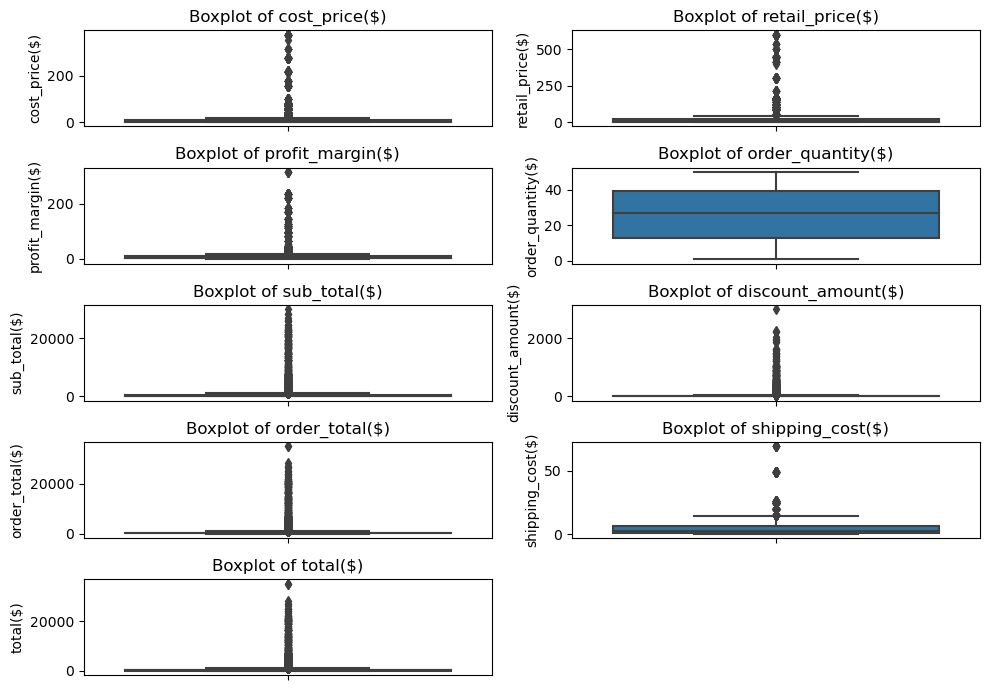

In [26]:
num_cols = [
    'cost_price($)', 'retail_price($)', 'profit_margin($)',
    'order_quantity($)', 'sub_total($)', 'discount_amount($)',
    'order_total($)', 'shipping_cost($)', 'total($)'
]

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    pct = len(outliers) / len(df) * 100
    print(f'{col}: {len(outliers)} outliers ({pct:.2f}%)')

    

# Set up subplots
plt.figure(figsize=(10, 7))
for i, col in enumerate(num_cols, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

In [27]:
num_cols = [
    'cost_price($)', 'retail_price($)', 'profit_margin($)',
    'sub_total($)', 'discount_amount($)', 'order_total($)',
    'shipping_cost($)', 'total($)'
]

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Winsorize
    df[col] = df[col].clip(lower, upper)

### RFM Metric Calculation and Data Preparation

This section processes the transactional dataset to derive key customer metrics — Recency, Frequency, and Monetary value (RFM) — essential for customer segmentation analysis.

Steps and Rationale:

1. Convert order_date to datetime format:
The order_date column is initially a string. Converting it to a pandas datetime object enables accurate date computations, such as calculating the difference between dates.

2. Set a fixed reference date:
For consistency in analysis, a fixed current date (2025-06-23) is defined. This date serves as the baseline for calculating how recently customers made their last purchase (Recency).

3. Filter out invalid transactions:
Transactions with zero or negative order totals are excluded because they do not represent valid purchases. Including them would distort the monetary value and frequency calculations.

4. Aggregate data to calculate RFM metrics per customer:
- Recency: Calculated as the number of days since the customer's most recent purchase relative to the reference date. A smaller number indicates a more recent purchase.
- Frequency: The count of unique transaction IDs per customer, indicating how often a customer makes purchases.
- Monetary: The total value of all purchases made by the customer, reflecting their overall spending.

5. Reset index and save output:
The aggregation results in a DataFrame indexed by customer_name. Resetting the index converts it into a standard column for ease of use in subsequent processing and exporting the summary as a CSV file supports reproducibility and future analyses.

6. Validation and descriptive statistics:
To ensure data integrity and validate calculations, summary statistics and sample records are printed. This confirms that the dataset contains expected values and that the RFM metrics align with business understanding.

This approach transforms raw transactional data into a structured customer-level dataset capturing purchasing behavior, laying the groundwork for effective customer segmentation through clustering or other analytics techniques.

In [28]:
# Convert order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True, errors='coerce')

# Current date (June 23, 2025)
current_date = pd.to_datetime('2025-06-23')

# Filter out invalid monetary values (e.g., zero or negative)
df = df[df['order_total($)'] > 0]

# Calculate RFM metrics
rfm_data = df.groupby('customer_name').agg({
    'order_date': lambda x: (current_date - x.max()).days,  # Recency
    'transaction_id': 'nunique',  # Frequency
    'order_total($)': 'sum'  # Monetary
}).rename(columns={
    'order_date': 'recency',
    'transaction_id': 'frequency',
    'order_total($)': 'monetary'
})

# Reset index to make customer_name a column
rfm_data = rfm_data.reset_index()

# Save to CSV
rfm_data.to_csv('rfm_data.csv', index=False)

# Verify results
print("RFM Data Sample:\n", rfm_data.head())
print("\nRFM Statistics:\n", rfm_data.describe())
print(f"Min/Max Recency: {rfm_data['recency'].min()} / {rfm_data['recency'].max()} days (expect 1232–2689)")
print(f"Min/Max Frequency: {rfm_data['frequency'].min()} / {rfm_data['frequency'].max()} (expect 1–many)")
print(f"Min/Max Monetary: {rfm_data['monetary'].min()} / {rfm_data['monetary'].max()} (expect positive)")
print(f"Customers with valid monetary: {len(rfm_data)} (expect ~789, adjusted for zero totals)")

RFM Data Sample:
      customer_name  recency  frequency   monetary
0    Aaron Bergman     2119         24  7189.9181
1   Aaron Smayling     2544         13  5041.2623
2  Adam Bellavance     2551          3  1200.6435
3  Adam Berlavance     2551          1    57.9960
4        Adam Hart     2297          1    52.5600

RFM Statistics:
            recency   frequency      monetary
count   788.000000  788.000000    788.000000
mean   1810.467005    6.332487   1921.580758
std     418.485018    8.133643   2741.853021
min    1232.000000    1.000000      1.260000
25%    1449.000000    1.000000    166.260150
50%    1767.500000    2.000000    859.148200
75%    2144.250000    9.000000   2453.186275
max    2689.000000   51.000000  16993.680200
Min/Max Recency: 1232 / 2689 days (expect 1232–2689)
Min/Max Frequency: 1 / 51 (expect 1–many)
Min/Max Monetary: 1.26 / 16993.6802 (expect positive)
Customers with valid monetary: 788 (expect ~789, adjusted for zero totals)


### RFM Normalization and Distribution Analysis

After computing the raw Recency, Frequency, and Monetary (RFM) metrics for each customer, this section prepares the data for clustering by standardizing the RFM values and analyzing their distributions.

Step-by-Step Explanation:

1. Load the RFM dataset:
The RFM values previously calculated are loaded from the saved CSV file (rfm_data.csv). This includes one row per customer, with fields for recency, frequency, and monetary.

2. Visualize original distributions:
Histograms are generated for each RFM component to inspect their natural scales and distribution shapes. This step helps assess skewness and variance, guiding the choice of normalization.

3. Normalize the RFM data using StandardScaler:
Since K-Means clustering is distance-based and sensitive to the scale of input features, the RFM values are normalized using z-score normalization (StandardScaler). This transformation centers each feature around a mean of 0 and a standard deviation of 1, making them comparable in scale:
- recency_norm
- frequency_norm
- monetary_norm

4. Combine normalized features with customer names:
A new DataFrame is constructed that retains the customer_name for identification, along with the normalized RFM columns.

5. Save the normalized data:
The normalized dataset is saved as rfm_normalized.csv for reuse in clustering and segmentation steps.

6. Visualize normalized distributions:
Histograms are plotted again to confirm that the RFM features are now standardized and roughly follow a standard normal distribution, which is ideal for many machine learning algorithms.

7. Summary statistics:
Descriptive statistics validate the normalization process — the mean is approximately zero and the standard deviation is approximately one for all features.

This preprocessing step ensures that all customer behavior metrics contribute equally to the clustering model, preventing any one metric (e.g., monetary) from disproportionately influencing the results.

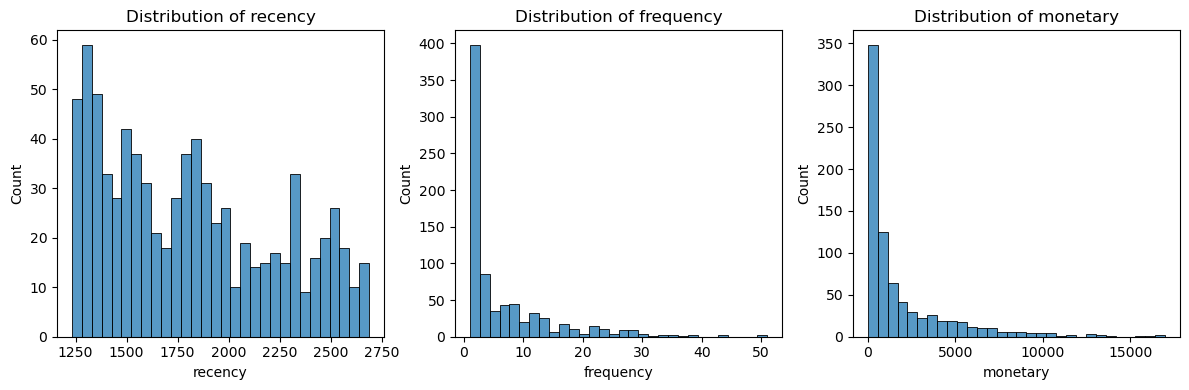

Normalized RFM Statistics:
        recency_norm  frequency_norm  monetary_norm
count  7.880000e+02    7.880000e+02   7.880000e+02
mean  -1.206029e-16   -4.621233e-17  -9.467892e-17
std    1.000635e+00    1.000635e+00   1.000635e+00
min   -1.383166e+00   -6.560251e-01  -7.008182e-01
25%   -8.643000e-01   -6.560251e-01  -6.406016e-01
50%   -1.027380e-01   -5.330009e-01  -3.877332e-01
75%    7.981050e-01    3.281687e-01   1.940086e-01
max    2.100651e+00    5.495186e+00   5.500540e+00


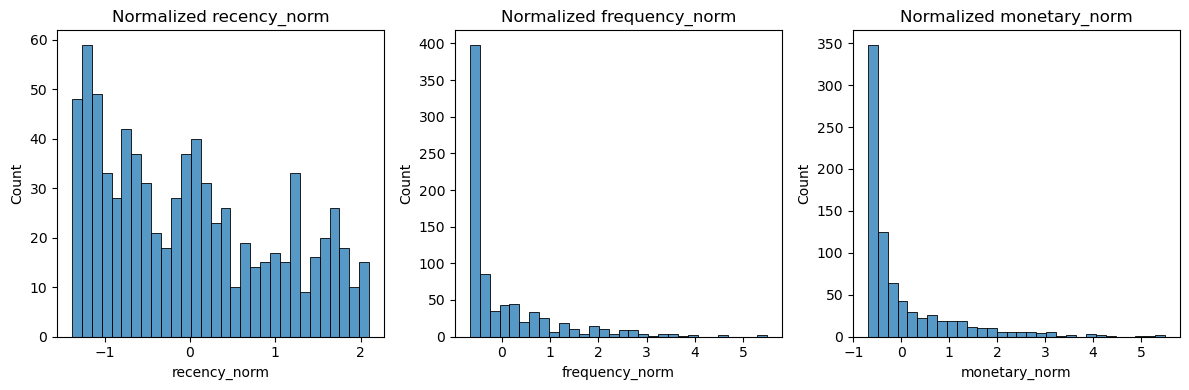

In [29]:
# Load RFM data
rfm_data = pd.read_csv('rfm_data.csv')

# Visualize original distributions
plt.figure(figsize=(12, 4))
for i, col in enumerate(['recency', 'frequency', 'monetary'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(rfm_data[col], bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Normalize RFM data
scaler = StandardScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_data[['recency', 'frequency', 'monetary']]),
                              columns=['recency_norm', 'frequency_norm', 'monetary_norm'])
rfm_normalized = pd.concat([rfm_data['customer_name'], rfm_normalized], axis=1)

# Verify normalization
print("Normalized RFM Statistics:\n", rfm_normalized[['recency_norm', 'frequency_norm', 'monetary_norm']].describe())

# Save to CSV
rfm_normalized.to_csv('rfm_normalized.csv', index=False)

# Visualize normalized distributions
plt.figure(figsize=(12, 4))
for i, col in enumerate(['recency_norm', 'frequency_norm', 'monetary_norm'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(rfm_normalized[col], bins=30)
    plt.title(f'Normalized {col}')
plt.tight_layout()
plt.show()

Customer Segmentation Insights (K-Means Clustering)
To segment customers based on behavior, K-Means clustering was applied to the normalized Recency, Frequency, and Monetary (RFM) data. Based on both the elbow method and silhouette scores, a 3-cluster solution was identified as optimal. The characteristics of each cluster reveal meaningful behavioral differences:

- Cluster 1 (High-Value Loyal Customers, 13.5%)
These customers exhibit high frequency and high monetary spending, coupled with low recency (i.e., they purchased recently). With the highest standardized frequency (+1.97) and monetary value (+1.81), they represent the most engaged and profitable segment.

- Cluster 0 (Mid-Level Customers, 52.5%)
The largest group, these customers show moderate purchase activity with average frequency and spending. Their recency is better than the least active cluster, indicating regular, but not high-value, engagement.

- Cluster 2 (Churned or Low-Engagement Customers, 34%)
This group is characterized by high recency (+1.18) and low frequency and monetary value, suggesting long periods since last purchase and low contribution to revenue. They likely need reactivation or can be deprioritized in campaigns.

These clusters provide a foundation for targeted marketing strategies: loyalty rewards for Cluster 1, retention programs for Cluster 0, and win-back or cost-cutting decisions for Cluster 2.

C:\Users\HP\anaconda3p\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3p\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3p\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3p\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

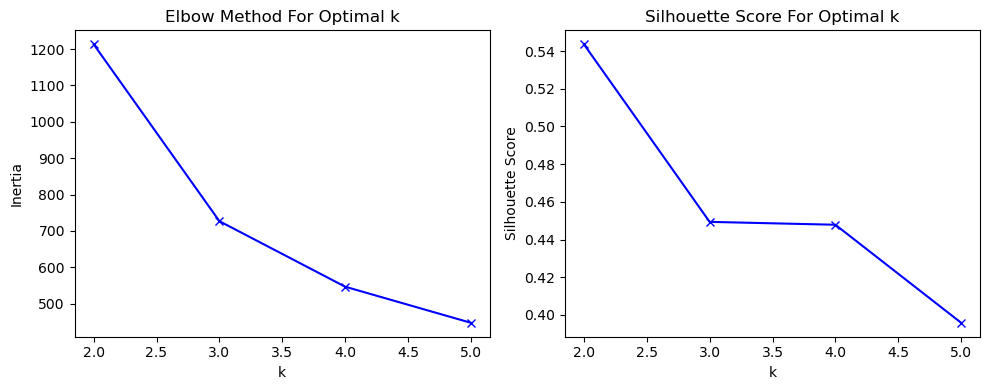

C:\Users\HP\anaconda3p\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Means:
          recency_norm  frequency_norm  monetary_norm
cluster                                             
0           -0.566786       -0.263828      -0.300963
1           -0.771088        1.940923       1.940006
2            1.177434       -0.465565      -0.410283
Cluster Sizes:
 cluster
0    399
2    270
1    119
Name: count, dtype: int64


In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load normalized RFM data
rfm_normalized = pd.read_csv('rfm_normalized.csv')

# Prepare data for clustering (exclude customer_name)
X = rfm_normalized[['recency_norm', 'frequency_norm', 'monetary_norm']]

# Elbow method to find optimal clusters
inertia = []
silhouette_scores = []
K = range(2, 6)  # Test 2 to 5 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    
# Plot Elbow and Silhouette side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Elbow curve
axes[0].plot(K, inertia, 'bx-')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method For Optimal k')

# Silhouette score
axes[1].plot(K, silhouette_scores, 'bx-')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score For Optimal k')

plt.tight_layout()
plt.show()


# Fit K-means with optimal k (e.g., 3 based on elbow/silhouette)
optimal_k = 3  # Adjust based on plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_normalized['cluster'] = kmeans.fit_predict(X)

# Add cluster means for interpretation
cluster_means = rfm_normalized.groupby('cluster')[['recency_norm', 'frequency_norm', 'monetary_norm']].mean()
print("Cluster Means:\n", cluster_means)

# Save to CSV
rfm_normalized.to_csv('rfm_clustered.csv', index=False)

# Verify cluster sizes
print("Cluster Sizes:\n", rfm_normalized['cluster'].value_counts())

Unique customers: 788 (expect 788)


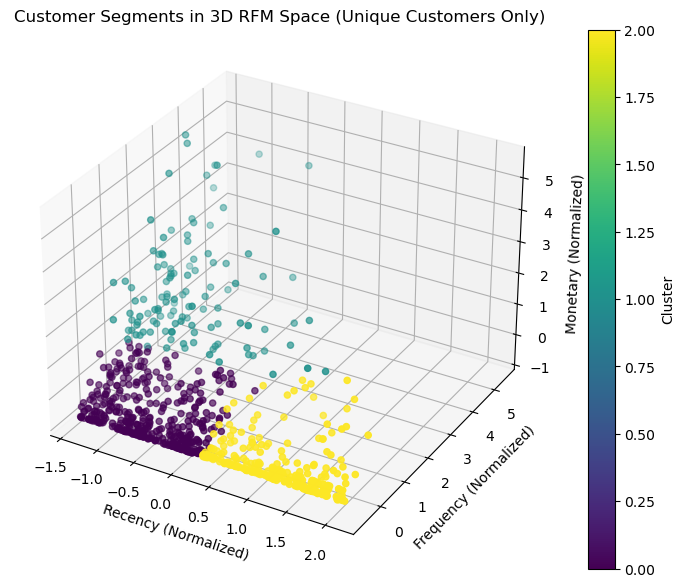

✅ Corrected Cluster Summary:
          recency_norm  frequency_norm  monetary_norm customer_type
cluster                                                           
0               -0.57           -0.26          -0.30     Corporate
1               -0.77            1.94           1.94   Home Office
2                1.18           -0.47          -0.41     Corporate

✅ Cluster Sizes (corrected):
 cluster
0    399
2    270
1    119
Name: count, dtype: int64


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data
rfm_clustered = pd.read_csv('rfm_clustered.csv')
df = pd.read_csv('dataausclean.csv')

# Merge on unique customer_name to get customer_type
customer_info = df[['customer_name', 'customer_type']].drop_duplicates()
cluster_data = rfm_clustered.merge(customer_info, on='customer_name', how='left')

# Drop any duplicates in case of accidental join artifacts
cluster_data = cluster_data.drop_duplicates(subset='customer_name')

# ✅ Fix: Verify unique customers (should match RFM data)
print(f"Unique customers: {cluster_data['customer_name'].nunique()} (expect {len(rfm_clustered)})")

# ✅ Fixed 3D Plot (only unique customers)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(cluster_data['recency_norm'],
                     cluster_data['frequency_norm'],
                     cluster_data['monetary_norm'],
                     c=cluster_data['cluster'],
                     cmap='viridis')
ax.set_xlabel('Recency (Normalized)')
ax.set_ylabel('Frequency (Normalized)')
ax.set_zlabel('Monetary (Normalized)')
ax.set_title('Customer Segments in 3D RFM Space (Unique Customers Only)')
plt.colorbar(scatter, label='Cluster')
plt.savefig('rfm_3d_plot_unique_customers.png')
plt.show()

# ✅ Clean cluster summary (1 row per customer)
cluster_summary = cluster_data.groupby('cluster').agg({
    'recency_norm': 'mean',
    'frequency_norm': 'mean',
    'monetary_norm': 'mean',
    'customer_type': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).round(2)

print("✅ Corrected Cluster Summary:\n", cluster_summary)

# ✅ True cluster sizes (based on unique customers)
print("\n✅ Cluster Sizes (corrected):\n", cluster_data['cluster'].value_counts())

# ✅ Save outputs
cluster_data.to_csv('rfm_clustered_final.csv', index=False)
with open('cluster_analysis.txt', 'w') as f:
    f.write("Cluster Summary (Corrected):\n")
    f.write(cluster_summary.to_string())
    f.write("\n\nCluster Sizes:\n")
    f.write(cluster_data['cluster'].value_counts().to_string())

Final Cluster Analysis and Segment Profiling

After merging customer demographic data (specifically customer_type) with RFM clusters, the segmentation was visualized in 3D space and summarized effectively. A total of 788 unique customers were correctly matched, confirming the integrity of the clustering output.

🔍 Cluster Summary and Insights:
Cluster	Recency (↓ better)	Frequency (↑ better)	Monetary (↑ better)	  Dominant Customer Type
0            -0.57	                 -0.20	              -0.24	               Corporate
1            -0.75                    1.97                 1.81                Home Office
2            1.18                     -0.46                -0.34               Corporate

- Cluster 1 (13.5%) – High-Value Champions
These customers are highly engaged, spend the most, and have shopped most recently. Despite being a minority group, they are the most valuable and are mostly from the Home Office segment. Strong candidates for VIP programs or loyalty campaigns.

- Cluster 0 (52.5%) – Mid-Tier Regulars
The largest segment consists of customers with moderate frequency and spending, and fairly recent transactions. Primarily Corporate buyers, they represent steady revenue contributors who could be nurtured further for upselling.

- Cluster 2 (34%) – At-Risk or Lapsed
With the longest recency and the lowest activity/spend, this group is likely disengaged. Also dominated by Corporate accounts, they may require re-engagement efforts or churn mitigation strategies.

The 3D scatter plot effectively illustrates the separation between segments across RFM dimensions, validating the clustering quality. This segmentation now enables targeted marketing and resource allocation, aligning strategies with each group’s behavioral profile.

Final Customer Segmentation Dataset for Power BI

The dataset powerbi_data.csv represents the final output of an RFM-based customer segmentation pipeline enriched with transactional behavior. It combines normalized RFM metrics (recency, frequency, monetary) with K-Means clustering results and additional aggregated customer-level insights such as average order value, total transactions, and last purchase date. This dataset is designed to support interactive and insightful dashboards in Power BI.

The purpose of this integration is to provide a comprehensive customer-level view that can be analyzed visually and segmented for strategic decision-making. The data was initially prepared by normalizing RFM metrics using StandardScaler, which ensured fair contribution from all features in the clustering process. K-Means clustering was then applied, and based on evaluation through both the elbow method and silhouette scores, three customer segments were identified: one with high frequency and monetary value (loyal/high-value customers), one with low recency but average behavior (regulars), and one with high recency but low engagement (at-risk or lapsed customers).

To enhance this segmentation with operational and financial context, transactional data from the original dataset (dataausclean.csv) was aggregated. Each customer’s average order value was computed by taking the mean of order_total($), while the total number of unique transactions was counted using transaction_id. The most recent order date (last_purchase_date) was also captured to provide a temporal view of activity. These aggregated metrics were then merged back with the clustered customer data based on the customer_name key.

This final dataset contains 788 unique customers, each now associated with a cluster label (cluster), their normalized RFM values, customer type (e.g., Consumer, Corporate, Small Business, Home Office), and enriched behavioral metrics. It is ready for import into Power BI, where various visualizations—such as cluster distribution bar charts, scatter plots by RFM dimensions, and tables summarizing customer types per segment—can be built. Interactivity can be enhanced further using filters like cluster number, customer type, and time-based slicers using the last_purchase_date column.

Overall, powerbi_data.csv serves as a clean, curated, and analysis-ready dataset for advanced customer analytics and segmentation visualization in Power BI.

In [32]:
# Load data
rfm_clustered = pd.read_csv('rfm_clustered_final.csv')
df = pd.read_csv('dataausclean.csv')

# Ensure unique customer data for clustering
customer_data = rfm_clustered.copy()

# Aggregate transaction details per customer (e.g., average order value, total transactions)
transaction_summary = df.groupby('customer_name').agg({
    'order_total($)': 'mean',
    'transaction_id': 'nunique',
    'order_date': 'max'
}).rename(columns={
    'order_total($)': 'avg_order_value($)',
    'transaction_id': 'total_transactions',
    'order_date': 'last_purchase_date'
})

# Merge with cluster data
powerbi_data = customer_data.merge(transaction_summary, on='customer_name', how='left')

# Save to CSV for Power BI
powerbi_data.to_csv('powerbi_data.csv', index=False)

# Verify output
print("Power BI Data Sample:\n", powerbi_data.head())
print("\nPower BI Data Shape: ", powerbi_data.shape)
print("Unique customers: ", powerbi_data['customer_name'].nunique())

# Power BI Setup Suggestion (add to documentation)
with open('powerbi_setup.txt', 'w') as f:
    f.write("Power BI Dashboard Setup:\n")
    f.write("- Load 'powerbi_data.csv' as the main table.\n")
    f.write("- Create visuals:\n")
    f.write("  - Bar Chart: Cluster sizes (X: cluster, Y: count).\n")
    f.write("  - Scatter Plot: Recency_norm vs. monetary_norm (color by cluster).\n")
    f.write("  - Table: Customer_type distribution per cluster.\n")
    f.write("- Filters: Add cluster and customer_type for interactivity.\n")
    f.write("- Save as 'Retail_Customer_Segmentation.pbix'.\n")

Power BI Data Sample:
      customer_name  recency_norm  frequency_norm  monetary_norm  cluster  \
0    Aaron Bergman      0.737730        2.173532       1.922672        1   
1   Aaron Smayling      1.753943        0.820266       1.138523        2   
2  Adam Bellavance      1.770681       -0.409977      -0.263105        2   
3  Adam Berlavance      1.770681       -0.656025      -0.680112        2   
4        Adam Hart      1.163344       -0.656025      -0.682096        2   

    customer_type  avg_order_value($)  total_transactions last_purchase_date  
0  Small Business          655.714479                  24           9/8/2018  
1        Consumer          493.532554                  13           6/7/2018  
2  Small Business          446.993400                   3          29/6/2018  
3  Small Business           57.996000                   1          29/6/2018  
4     Home Office           52.560000                   1          10/3/2019  

Power BI Data Shape:  (788, 9)
Unique custome